In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib.pyplot as plt

Считываем вход из файлов и преобразуем в DataFrame. Кроме того, если необходимо выполнить преобразование входа, можно передать соответствующую трансформирующую функцию *map_f*

In [2]:
INPUT_PATH = './input/'

def read_base(N, map_f=None):
    LINES = 10**6
    path = '{}Base{}.txt'.format(INPUT_PATH, N)
    X, y = [], []
    with open(path, 'r') as fin:
        for _ in tqdm(xrange(LINES)):
            for l in fin.readlines():
                x = l.split()[0]
                if map_f:
                    X.append(map_f(x))
                else:
                    X.append(list(x))
                y.append(l.split()[1])
    print 'converting to dataframe...'
    return pd.DataFrame(X, dtype=int), pd.Series(y, dtype=int)

Убедимся, что данные выглядят так, как надо:

In [3]:
X, y = read_base(8)
print X.shape, y.shape
print X[:5]
print y[:5]

100%|██████████| 1000000/1000000 [00:03<00:00, 320921.69it/s]


converting to dataframe...
(1000000, 8) (1000000,)
   0  1  2  3  4  5  6  7
0  1  0  0  0  1  0  0  1
1  0  0  1  0  1  0  1  1
2  1  1  1  1  1  0  1  1
3  1  0  1  0  1  0  1  1
4  1  0  1  1  0  0  0  0
0    0
1    0
2    1
3    1
4    1
dtype: int64


Определим функцию обучения для определенного классификатора. Предпочтение в разделение исходной выборки на train/test был отдан методу *train_test_split*, поскольку  *KFold* не имеет смысла, поскольку, например для *LogisticRegression*:

```warm_start : bool, default: False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. Useless for liblinear solver.```

Кроме того, будем выводить **confusion_matrix** для каждого результата обучения, а также метрику **accuracy** (*model.score*)

In [19]:
def learn(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
#     kf = KFold(n_splits=5)
#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
#         y_train, y_test = y[train_index], y[test_index]
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         cm = confusion_matrix(y_test, y_pred)
    print
    print cm
    score = model.score(X_test, y_test)
    print score
    return score

Здесь выполним трансформирующую функцию для входа. Помимо считанных значений из файла, попробуем добавить в качестве характеристик следующие параметры: посчитаем для каждого *i* переключателя характер распространения сигнала на нем, а именно, поменялись ли в итоге каналами сигналы или нет. Другими словами, если количество *1* четно до *i* блока, то сигналы идут по тем же каналам, как и были запущены из истока, иначе нет. Это достигается поэлементным ксором переключателей. Точно так же сделаем и для блоков, начиная с выхода (в обратном направлении)

In [ ]:
def try_map(x):
    all_xor = reduce(lambda kum, v: kum ^ int(v), x, 0)
    res = list(x)
    res.append(all_xor)
    cur_xor = all_xor
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    cur_xor = 0
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    return res

Проверим работоспособность с логистической регрессией на небольшом входе:

In [56]:
model = LogisticRegression(n_jobs=-1, random_state=6)
X, y = read_base(8, try_map)
print 'finished reading input...'
learn(X, y, model)


  0%|          | 0/1000000 [00:00<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/chiselko6/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/chiselko6/anaconda/lib/python2.7/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/chiselko6/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|██████████| 1000000/1000000 [00:18<00:00, 52968.41it/s]

converting to dataframe
finished reading input...
[[ 81198      0]
 [     0 118802]]
1.0
[[ 81179      0]
 [     0 118821]]
1.0
[[ 81714      0]
 [     0 118286]]
1.0
[[ 81094      0]
 [     0 118906]]
1.0
[[ 81224      0]
 [     0 118776]]
1.0


Определим функцию для сравнения результатов обучения без применения т.н. "feature engineering" и вместе с ним:

In [10]:
def try_both(N, model):
    X, y = read_base(N)
    learn(X, y, model)
    
    X, y = read_base(N, try_map)
    learn(X, y, model)

Выполним обучение для всех возможных *BaseN* с выбранной моделью, параллельно насчитывая время, затраченное на чтение/обучение:

In [ ]:
def check_all_N(model, N_from=8, N_to=130):
    scores = []
    Ns = range(N_from, N_to, 8)
    
    def run(N):
        print 'running with map for N={}'.format(N)
        X, y = read_base(N, try_map)
        return learn(X, y, model)
    
    for N in Ns:
        st = time.clock()
        scores.append(run(N))
        print time.clock() - st

    plt.figure(figsize=(16, 7))
    plt.plot(Ns, scores)
    plt.title('Score')
    plt.xlabel('N')
    plt.ylabel('Score')
    plt.show()

Запустим логистическую регрессию:

  0%|          | 0/1000000 [00:00<?, ?it/s]

running with map for N=8


100%|██████████| 1000000/1000000 [00:17<00:00, 58058.59it/s]


converting to dataframe...


  0%|          | 0/1000000 [00:00<?, ?it/s]


[[ 81460      0]
 [     0 118540]]
1.0
1 loop, best of 1: 29.7 s per loop
running with map for N=16


100%|██████████| 1000000/1000000 [00:31<00:00, 31668.72it/s]


converting to dataframe...


  0%|          | 0/1000000 [00:00<?, ?it/s]


[[ 96281    198]
 [   433 103088]]
0.996845
1 loop, best of 1: 1min 4s per loop
running with map for N=24


100%|██████████| 1000000/1000000 [00:46<00:00, 21499.08it/s]


converting to dataframe...

  0%|          | 0/1000000 [00:00<?, ?it/s]



[[99541   449]
 [  536 99474]]
0.995075
1 loop, best of 1: 1min 28s per loop
running with map for N=32


100%|██████████| 1000000/1000000 [00:56<00:00, 17586.58it/s]


converting to dataframe...


  0%|          | 0/1000000 [00:00<?, ?it/s]


[[ 89447    591]
 [   521 109441]]
0.99444
1 loop, best of 1: 1min 47s per loop
running with map for N=40


100%|██████████| 1000000/1000000 [01:09<00:00, 14290.99it/s]


converting to dataframe...

[[ 91149    574]
 [   581 107696]]
0.994225

  0%|          | 0/1000000 [00:00<?, ?it/s]


1 loop, best of 1: 2min 15s per loop
running with map for N=48


100%|██████████| 1000000/1000000 [01:22<00:00, 12055.09it/s]


converting to dataframe...

[[103040    573]
 [   601  95786]]
0.99413

  0%|          | 0/1000000 [00:00<?, ?it/s]


1 loop, best of 1: 2min 43s per loop
running with map for N=56


100%|██████████| 1000000/1000000 [01:36<00:00, 10366.36it/s]


converting to dataframe...

[[ 88050    609]
 [   636 110705]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.993775
1 loop, best of 1: 3min 12s per loop
running with map for N=64


100%|██████████| 1000000/1000000 [01:49<00:00, 9101.42it/s]


converting to dataframe...

[[ 96694    637]
 [   609 102060]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.99377
1 loop, best of 1: 3min 44s per loop
running with map for N=72


100%|██████████| 1000000/1000000 [02:02<00:00, 8171.62it/s]


converting to dataframe...

[[ 92839    623]
 [   682 105856]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.993475
1 loop, best of 1: 4min 14s per loop
running with map for N=80


100%|██████████| 1000000/1000000 [02:15<00:00, 7364.94it/s]


converting to dataframe...

[[98861   698]
 [  628 99813]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.99337
1 loop, best of 1: 4min 46s per loop
running with map for N=88


100%|██████████| 1000000/1000000 [02:28<00:00, 6724.06it/s]


converting to dataframe...

[[ 91666    695]
 [   707 106932]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.99299
1 loop, best of 1: 5min 22s per loop
running with map for N=96


100%|██████████| 1000000/1000000 [02:56<00:00, 5666.47it/s]


converting to dataframe...

[[99637   744]
 [  843 98776]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.992065
1 loop, best of 1: 6min 44s per loop
running with map for N=104


100%|██████████| 1000000/1000000 [03:28<00:00, 4801.99it/s]


converting to dataframe...

[[ 85768    812]
 [   799 112621]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.991945
1 loop, best of 1: 7min 39s per loop
running with map for N=112


100%|██████████| 1000000/1000000 [03:33<00:00, 4680.33it/s]


converting to dataframe...

[[ 93418    806]
 [   853 104923]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.991705
1 loop, best of 1: 8min 8s per loop
running with map for N=120


100%|██████████| 1000000/1000000 [04:03<00:00, 4105.95it/s]


converting to dataframe...

[[ 92996    781]
 [   871 105352]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.99174
1 loop, best of 1: 8min 58s per loop
running with map for N=128


100%|██████████| 1000000/1000000 [03:59<00:00, 4176.73it/s]


converting to dataframe...

[[ 75917    863]
 [   838 122382]]
0.991495
1 loop, best of 1: 8min 48s per loop


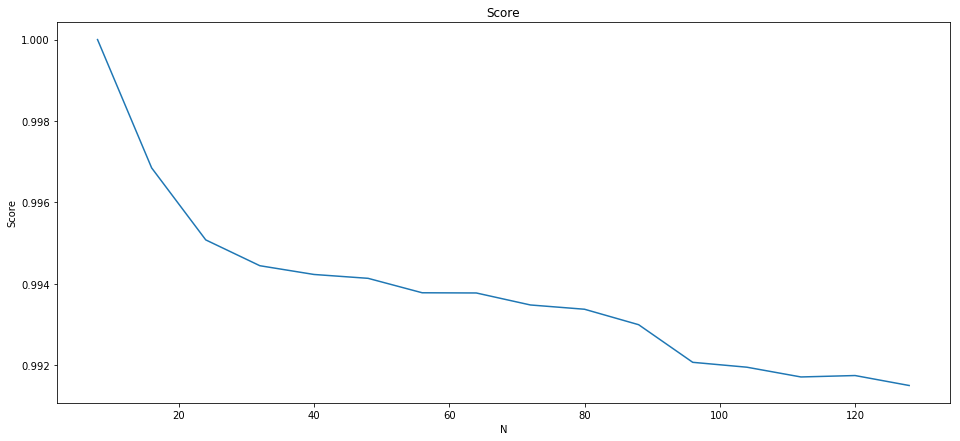

In [95]:
model = LogisticRegression(n_jobs=-1, random_state=6)
check_all_N(model)

Запустим KNN:

In [ ]:
model = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
X, y = read_base(16, try_map)
learn(X, y, model)

100%|██████████| 1000000/1000000 [00:34<00:00, 28986.71it/s]


converting to dataframe...


Попробуем сходимость SVM классификатора на небольшом входе:

In [11]:
model = LinearSVC(max_iter=10000, random_state=6, verbose=5)
try_both(16, model)

100%|██████████| 1000000/1000000 [00:03<00:00, 262888.91it/s]


converting to dataframe...
[LibLinear]

  0%|          | 0/1000000 [00:00<?, ?it/s]


[[59675 36804]
 [40623 62898]]
0.612865


100%|██████████| 1000000/1000000 [00:32<00:00, 30872.50it/s]


converting to dataframe...
[LibLinear]
[[ 96247    232]
 [   367 103154]]
0.997005


И запустим его для больших *BaseN* ($N >= 96$), чтобы сэкономить время:

  0%|          | 0/1000000 [00:00<?, ?it/s]

running with map for N=96


100%|██████████| 1000000/1000000 [03:15<00:00, 5113.80it/s]


converting to dataframe...
[LibLinear]
[[99634   747]
 [  830 98789]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.992115
468.736058
running with map for N=104


100%|██████████| 1000000/1000000 [03:22<00:00, 4945.25it/s]


converting to dataframe...
[LibLinear]
[[ 85786    794]
 [   786 112634]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.9921
507.055241
running with map for N=112


100%|██████████| 1000000/1000000 [03:39<00:00, 4563.24it/s]


converting to dataframe...
[LibLinear]
[[ 93427    797]
 [   822 104954]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.991905
557.011317
running with map for N=120


100%|██████████| 1000000/1000000 [03:56<00:00, 4221.57it/s]


converting to dataframe...
[LibLinear]
[[ 93016    761]
 [   848 105375]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.991955
605.64796
running with map for N=128


100%|██████████| 1000000/1000000 [04:25<00:00, 3769.43it/s]


converting to dataframe...
[LibLinear]
[[ 75946    834]
 [   818 122402]]
0.99174
672.067948


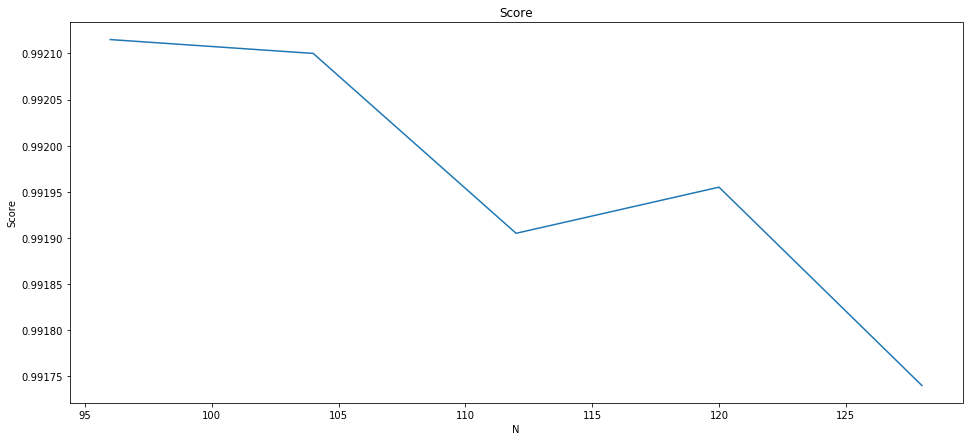

In [48]:
model = LinearSVC(max_iter=10000, random_state=6, verbose=5)
check_all_N(model, N_from=96)

Попробуем использовать деревья решений:

  0%|          | 0/1000000 [00:00<?, ?it/s]

running with map for N=96


100%|██████████| 1000000/1000000 [03:16<00:00, 5087.21it/s]


converting to dataframe...

[[64855 35526]
 [40876 58743]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.61799
432.310273
running with map for N=104


100%|██████████| 1000000/1000000 [03:24<00:00, 4896.04it/s]


converting to dataframe...

[[51334 35246]
 [41395 72025]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.616795
463.352975
running with map for N=112


100%|██████████| 1000000/1000000 [03:34<00:00, 4671.24it/s]


converting to dataframe...

[[57794 36430]
 [42708 63068]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.60431
490.879261
running with map for N=120


100%|██████████| 1000000/1000000 [03:46<00:00, 4406.22it/s]


converting to dataframe...

[[57286 36491]
 [42901 63322]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.60304
527.616068
running with map for N=128


100%|██████████| 1000000/1000000 [04:24<00:00, 3782.97it/s]


converting to dataframe...

[[41392 35388]
 [42541 80679]]
0.610355
577.908446


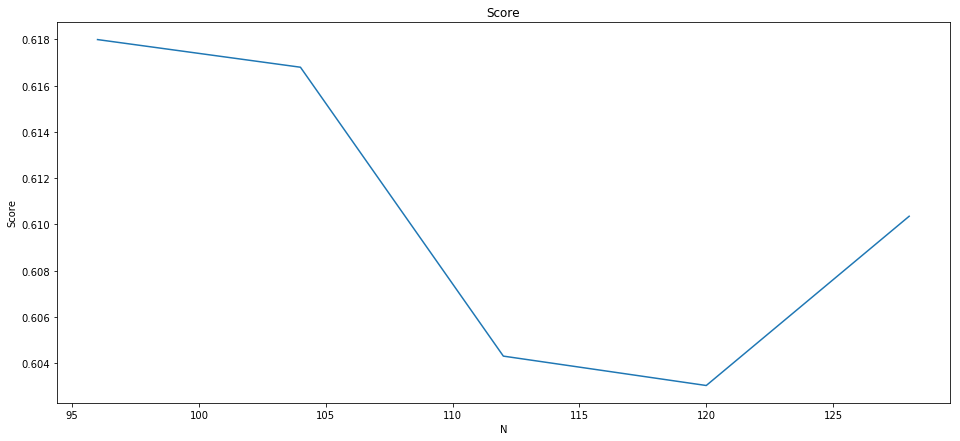

In [50]:
model = DecisionTreeClassifier(min_samples_leaf=4)
check_all_N(model, N_from=96)